---
format: 
  html:
    toc: true
    number-sections: true
    code-fold: true
execute:
  echo: true
---

# Gather and Explore Additional Modeling Data

To support more strategic trash removal scheduling, our proposed tool leverages historical data and forecasted trends to provide insights into next year's anticipated trash reporting incidents. This section compiles the following additional independent features hypothesized to correlate with trash complaint counts for year 2022-2023, which will be used as modeling data in the later sections. 

- **sociodemographic factors**: `median household income`, `share of non-white population`, `share of hispanic-latino population`, `poverty rate`, and `average household size`. The data is retrieved from 2018-2023 5-year American Community Survey using API. These factors are common indicators of low-income and minority communities, who may be prone to systematic disinvestment.
- `restaurant violation inspections`: Higher volumes of trash-related restaurant violation not only indicate lack of trash management, but also high human activities.
- **other 311 requests**: `derelict vehicles` and `graffiti` are also reported to DSNY and reflect poorly managed locations prone to trash dumping.
- **weather**: daily records of `average temperature`, `precipitation`, and `snow` is gathered, as these factors can exacerbate conditions of trash overflow, or impact human activities.
- `litter basket`: the distribution of litter basket likely have an impact on accessibility of waste disposal locations, hence impacting local sanitation conditions.
- `traffic (auto)`: the aggregated volume of road traffic in a neighborhood is an indicator of human activities and business vibrancy, thereby influencing the chance of trashing.
- **unique days**: `day of the week`, `week` and `holiday` indicate specific times of the week or year when human activities fluctuate. For instance, weekend evenings or holidays are more likely to involve social gatherings or food and drink-related activities, thereby increasing trash volumes.
- `lagged counts`: assuming that trashing trends exhibit similarities across adjacent years, the number of complaints on a specific date one year ago is considered to correlate with the count on the same date the following year.

In the following steps, we approached the data gathering process into lagged data versus forcasted data, based on careful consideration of data availability and common release date.

## Set Up

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
import cenpy
import pygris

import seaborn as sns
!pip install hvplot
import holoviews as hv
hv.extension('bokeh') 
from datashader.colors import viridis
import hvplot.pandas

from shapely.wkt import loads
from shapely.geometry import MultiLineString
from shapely.ops import nearest_points

from datetime import datetime
import matplotlib.pyplot as plt

!pip install meteostat
from meteostat import Point, Daily, Stations

!pip install holidays
import holidays

# Show all columns in dataframes
pd.options.display.max_columns = 999

# Hide warnings due to issue in shapely package 
# See: https://github.com/shapely/shapely/issues/1345
np.seterr(invalid="ignore");

## Load DSNY Boundary and Complaint Data (2022 and 2023)

### Load DSNY Boundary

In [2]:
DSNY_boundary = gpd.read_file('data/1_DSNY_boundary_processed.geojson')

# Reproject to state plane
DSNY_boundary = DSNY_boundary.to_crs(epsg=2263)

### Load Complaint Data

In [3]:
# Load 2022 data
complaints_22 = pd.read_parquet('data/1_complaints_DSNY_full_2022.parquet')

In [4]:
# Load 2023 data
complaints_23 = pd.read_parquet('data/1_complaints_DSNY_full_2023.parquet')

In [5]:
# Convert date to the right format
complaints_22['Created Date'] = pd.to_datetime(complaints_22['Created Date'], errors='coerce')
complaints_23['Created Date'] = pd.to_datetime(complaints_23['Created Date'], errors='coerce')

## Lagged Data Gathering

A key restriction to the model's feasibility is availability of data. To predict an upcoming year's trash removal taskforce scheduling, we will leverage the following data based on the previous years' records, including:
- **sociodemographic factors**: `median household income`, `share of non-white population`, `share of hispanic-latino population`, `poverty rate`, and `average household size`
- `restaurant violation inspections`
- **other 311 requests**: `derelict vehicles` and `graffiti`
- **weather**: daily records of `average temperature`, `precipitation`, and `snow`
- `lagged counts`: ie. Number of Complaints filed on 2022-01-01 will be used to predict for 2023-01-01, completed in Section 1

### Gather 2022 ACS 5-year data

#### Data Gathering

In [6]:
variables = ["NAME",
             "B19013_001E", #median hh income
             "B01003_001E", #total pop
             "B03002_003E", #white alone
             "B03002_012E", #hispanic-latino total
             "B06012_002E", #poverty rate
             "B25010_001E" #average hh size
            ]

acs = cenpy.remote.APIConnection("ACSDT5Y2022")

NYC_county_code = ["005", "047", "061", "081", "085"]
NYC_code = "36"
NYC_county_string = ",".join(NYC_county_code)

acs_vars = acs.query(
    cols=variables,
    geo_unit="tract:*",
    geo_filter={"state": NYC_code, "county": NYC_county_string},
)

# Rename columns
acs_vars.rename(columns={
    "B19013_001E": "Med_HH_Inc", 
    "B01003_001E": "Tot_Pop", 
    "B03002_003E": "White_Alone",
    "B03002_012E": "Hispanic_Latino",
    "B06012_002E": "Poverty_Pop",
    "B25010_001E": "Avg_HH_Size"
}, inplace=True)

# Convert to Numeric
exclude_cols= ['NAME', 'tract', 'state', 'county']
acs_vars.loc[:, ~acs_vars.columns.isin(exclude_cols)] = (
    acs_vars.loc[:, ~acs_vars.columns.isin(exclude_cols)]
    .apply(pd.to_numeric, errors='coerce')
)

# Remove invalid results
acs_vars = acs_vars[
    (acs_vars['Med_HH_Inc'] != -666666666) & 
    (acs_vars['Avg_HH_Size'] != -666666666)
]
acs_vars = acs_vars.reset_index(drop=True)

# calculate race/ethnicity share
acs_vars['Pct_Non_White'] = (1 - (acs_vars['White_Alone'] / acs_vars['Tot_Pop'])) * 100
acs_vars['Pct_Hispanic'] = (acs_vars['Hispanic_Latino'] / acs_vars['Tot_Pop']) * 100
acs_vars['Poverty_Rate'] = (acs_vars['Poverty_Pop'] / acs_vars['Tot_Pop']) * 100

# Modify GEOID of the acs_vars data frame
acs_vars["GEOID"] = (
    acs_vars["state"].astype(str).str.zfill(2) +  
    acs_vars["county"].astype(str).str.zfill(3) +
    acs_vars["tract"].astype(str).str.zfill(6)
)

# select necessary columns
acs_vars = acs_vars[["GEOID", "Med_HH_Inc", "Pct_Non_White", "Pct_Hispanic", "Poverty_Rate", "Avg_HH_Size"]]

# Get NYC tracts boundaries
NYC_tracts = pygris.tracts(state="36", county=NYC_county_code, year=2022)

# Merge info with tract boundaries
acs_vars_tracts= acs_vars.merge(NYC_tracts, on="GEOID", how="left")

# select necessary columns
acs_vars_tracts = acs_vars_tracts[["GEOID", "Med_HH_Inc", "Pct_Non_White", "Pct_Hispanic", "Poverty_Rate", "Avg_HH_Size","geometry"]]

#### Join ACS Variables with DSNY Boundaries

In [7]:
# Calculate centroids of DSNY_boundary
DSNY_boundary['centroid'] = DSNY_boundary.geometry.centroid
DSNY_centroids = DSNY_boundary.set_geometry('centroid')

DSNY_boundary = DSNY_boundary.drop(columns=['centroid'])

# Ensure CRS matches between the two datasets
acs_vars_tracts = gpd.GeoDataFrame(acs_vars_tracts, geometry=acs_vars_tracts['geometry'], crs="EPSG:4326")
acs_vars_tracts = acs_vars_tracts.to_crs(DSNY_boundary.crs)

# Perform spatial join to match centroids with ACS tract data
DSNY_boundary_with_acs = gpd.sjoin(DSNY_centroids, acs_vars_tracts, how="left", predicate="intersects").drop(columns=['index_right'])

DSNY_boundary_with_acs = DSNY_boundary_with_acs.drop(columns=['centroid'])

#### Join ACS Variables with Complaints Data by District

In [8]:
complaints_22 = (complaints_22.merge(DSNY_boundary_with_acs, on="DSNY_ID", how="left"))

### Gather 2022 NYC Restaurants Violation Data

*Note: the data loaded is pre-processed in section "Trim Additional Data".* 

#### Data Gathering

In [9]:
restaurant_violations = pd.read_csv("data/sanitation_related_restaurant_inspections.csv")

#### Join Restaurant Violations with DSNY Boundaries

In [10]:
# Convert restaurant violations data to a GeoDataFrame
restaurant_violations = restaurant_violations[['CAMIS', 'INSPECTION DATE', 'Latitude', 'Longitude']]

restaurant_violations = gpd.GeoDataFrame(
  restaurant_violations, geometry=gpd.points_from_xy(restaurant_violations.Longitude, restaurant_violations.Latitude), crs="EPSG:4326"
  )

restaurant_violations = restaurant_violations.to_crs(DSNY_boundary.crs)

# Perform spatial join - identify which DSNY district the restaurant is associated with 
DSNY_boundary_with_rv = gpd.sjoin(restaurant_violations, DSNY_boundary, how="right", predicate="within")

# Group violation inspections by district and date
DSNY_boundary_with_rv = (
    DSNY_boundary_with_rv.groupby(['DSNY_ID', 'INSPECTION DATE'])['CAMIS']
    .nunique()
    .reset_index()
)

DSNY_boundary_with_rv.rename(columns={'CAMIS': 'Restaurant Inspection Count'}, inplace=True)

DSNY_boundary_with_rv.rename(columns={"INSPECTION DATE": "Created Date"}, inplace=True)

#### Join Restaurant Violations with Complaints Data by District and Date

In [11]:
# Join with complaints data 2022
DSNY_boundary_with_rv['Created Date'] = pd.to_datetime(DSNY_boundary_with_rv['Created Date'], format='%m/%d/%Y', errors='coerce')

# Join with the time series dataframe
complaints_22 = complaints_22.merge(
    DSNY_boundary_with_rv,
    on=["Created Date", "DSNY_ID"],  
    how="left"                       
)

### Gather 2022 NYC Other 311 Data

*Note: The loaded datasets were pre-processed in section "Trim Additional Data".*

#### Data Gathering

In [12]:
# Derelict Vehicles
derelict_vehicles = pd.read_parquet("data/derelict_vehicles.parquet")

# Graffiti
graffiti = pd.read_parquet("data/graffiti.parquet")

#### Join Other 311 Data with DSNY Boundaries

In [13]:
# Join derelict vehicles
    # Convert derelict vehicles data to a GeoDataFrame
derelict_vehicles = derelict_vehicles[['Unique Key', 'Created Date', 'Latitude', 'Longitude']]

derelict_vehicles = gpd.GeoDataFrame(
  derelict_vehicles, geometry=gpd.points_from_xy(derelict_vehicles.Longitude, derelict_vehicles.Latitude), crs="EPSG:4326"
  )

derelict_vehicles = derelict_vehicles.to_crs(DSNY_boundary.crs)

    # Perform spatial join
DSNY_boundary_with_dv = gpd.sjoin(derelict_vehicles, DSNY_boundary, how="right", predicate="within")

    # Group derelict vehicles by district and date
DSNY_boundary_with_dv = (
    DSNY_boundary_with_dv.groupby(['DSNY_ID', 'Created Date'])['Unique Key']
    .nunique()
    .reset_index()
)

DSNY_boundary_with_dv.rename(columns={'Unique Key': 'Derelict Vehicle Count'}, inplace=True)


# Join Graffiti
    # Convert graffiti data to a GeoDataFrame
graffiti = graffiti[['Unique Key', 'Created Date', 'Latitude', 'Longitude']]

graffiti = gpd.GeoDataFrame(
  graffiti, geometry=gpd.points_from_xy(graffiti.Longitude, graffiti.Latitude), crs="EPSG:4326"
  )

graffiti = graffiti.to_crs(DSNY_boundary.crs)

    # Perform spatial join
DSNY_boundary_with_g = gpd.sjoin(graffiti, DSNY_boundary, how="right", predicate="within")

    # Group graffiti by district and date
DSNY_boundary_with_g = (
    DSNY_boundary_with_g.groupby(['DSNY_ID', 'Created Date'])['Unique Key']
    .nunique()
    .reset_index()
)

DSNY_boundary_with_g.rename(columns={'Unique Key': 'Graffiti Count'}, inplace=True)

#### Join Other 311 Data with Complaints Data by District and Date

In [14]:
# Make sure dates are in datetime format
DSNY_boundary_with_dv['Created Date'] = pd.to_datetime(DSNY_boundary_with_dv['Created Date'], errors='coerce')
DSNY_boundary_with_g['Created Date'] = pd.to_datetime(DSNY_boundary_with_g['Created Date'], errors='coerce')

# Join derelict vehicle records with the time series dataframe
complaints_22 = complaints_22.merge(
    DSNY_boundary_with_dv,
    on=["Created Date", "DSNY_ID"],  
    how="left"                       
)

# Join graffiti records with the time series dataframe
complaints_22 = complaints_22.merge(
    DSNY_boundary_with_g,
    on=["Created Date", "DSNY_ID"],  
    how="left"                       
)

### Gather 2022 Weather Data

#### Data Gathering

In [15]:
# Define time range for weather data
weather_start = datetime(2022, 1, 1)
weather_end = datetime(2022, 12, 31)

# Location weather data station
stations = Stations()
stations = stations.nearby(40.7128, -74.0060)
station = stations.fetch()

In [16]:
# Location weather data station
stations = Stations()
stations = stations.nearby(40.7128, -74.0060)
station = stations.fetch()

# Pick station
JFK = station[station['name'] == "John F. Kennedy Airport"]

# Gather data
weather_data = Daily(JFK, weather_start, weather_end)
weather_data = weather_data.fetch()

# Reset the index to make 'time' a regular column
weather_data = weather_data.reset_index()

# Convert 'time' to datetime format
weather_data['time'] = pd.to_datetime(weather_data['time'], errors='coerce')

# Trim temperature, precipitation and snow data
weather_cols = ['time', 'tavg', 'prcp', 'snow']
weather_data = weather_data.loc[:, weather_data.columns.isin(weather_cols)]

# Rename columns
weather_data.rename(columns={
    "tavg": "avg_temp",
    "prcp": "precipitation"
}, inplace=True)

#### Join Weather Data with Complaints Data by Date

In [17]:
complaints_22 = complaints_22.merge(
    weather_data,
    left_on="Created Date",  
    right_on="time",        
    how="left"             
)

complaints_22 = complaints_22.drop(columns=['time'])

In [18]:
complaints_22

,DSNY_ID,Created Date,Complaint Count,geometry,GEOID,Med_HH_Inc,Pct_Non_White,Pct_Hispanic,Poverty_Rate,Avg_HH_Size,Restaurant Inspection Count,Derelict Vehicle Count,Graffiti Count,avg_temp,precipitation,snow
0,BKN011_A,2022-01-01,0.0,"MULTIPOLYGON (((995020.254 205025.197, 995260....",36047056100,146250.0,30.224904,13.878223,5.951728,2.11,NaN,NaN,NaN,10.1,31.0,0.0
1,BKN011_A,2022-01-02,0.0,"MULTIPOLYGON (((995020.254 205025.197, 995260....",36047056100,146250.0,30.224904,13.878223,5.951728,2.11,NaN,NaN,NaN,11.5,0.8,0.0
2,BKN011_A,2022-01-03,1.0,"MULTIPOLYGON (((995020.254 205025.197, 995260....",36047056100,146250.0,30.224904,13.878223,5.951728,2.11,NaN,NaN,NaN,1.2,0.0,0.0
3,BKN011_A,2022-01-04,0.0,"MULTIPOLYGON (((995020.254 205025.197, 995260....",36047056100,146250.0,30.224904,13.878223,5.951728,2.11,NaN,NaN,NaN,-3.8,0.0,0.0
4,BKN011_A,2022-01-05,0.0,"MULTIPOLYGON (((995020.254 205025.197, 995260....",36047056100,146250.0,30.224904,13.878223,5.951728,2.11,NaN,NaN,NaN,2.5,7.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222645,SI038_E,2022-12-27,1.0,"MULTIPOLYGON (((921213.717 128503.472, 921135....",36085024800,131146.0,19.098458,16.152629,6.58363,2.94,NaN,NaN,NaN,-0.9,0.0,0.0
222646,SI038_E,2022-12-28,0.0,"MULTIPOLYGON (((921213.717 128503.472, 921135....",36085024800,131146.0,19.098458,16.152629,6.58363,2.94,NaN,NaN,NaN,2.1,0.0,0.0
222647,SI038_E,2022-12-29,0.0,"MULTIPOLYGON (((921213.717 128503.472, 921135....",36085024800,131146.0,19.098458,16.152629,6.58363,2.94,NaN,NaN,NaN,3.7,0.0,0.0
222648,SI038_E,2022-12-30,0.0,"MULTIPOLYGON (((921213.717 128503.472, 921135....",36085024800,131146.0,19.098458,16.152629,6.58363,2.94,NaN,NaN,NaN,5.4,0.0,0.0


## Forecasted (Non-Lagged) Data Gathering

The following steps gather and process forecasted variables based on historic records. Since spatial factors (e.g., location of litter baskets, wider vs. narrower roads) tend to remain relatively constant over time, we projected counts and averages from past year(s) as forecasts for 2023 (the prediction year).

- `litter basket`: the distribution of litter basket likely have an impact on accessibility of waste disposal locations, hence impacting local sanitation conditions.
- `traffic (auto)`: the aggregated volume of road traffic in a neighborhood is an indicator of human activities and business vibrancy, thereby influencing the chance of trashing.

source: 
- DSNY Litter Basket, NYC Open Data [https://data.cityofnewyork.us/dataset/DSNY-Litter-Basket-Map-/d6m8-cwh9]
- Traffic Volume Counts, NYC Open Data [https://data.cityofnewyork.us/Transportation/Traffic-Volume-Counts/btm5-ppia/about_data]

### Gather Litter Basket Data

#### Data Gathering

In [19]:
litter_basket = pd.read_csv("data/DSNY_Litter_Basket_Inventory.csv")

#### Join Litter Basket Data with DSNY Boundaries

In [20]:
litter_basket['point'] = litter_basket['point'].apply(loads)

litter_basket_gdf = gpd.GeoDataFrame(
    litter_basket, 
    geometry=litter_basket['point'],
    crs="EPSG:4326"
)

litter_basket_gdf = litter_basket_gdf.to_crs(DSNY_boundary.crs)

DSNY_boundary_with_baskets = gpd.sjoin(litter_basket_gdf, DSNY_boundary, how="right", predicate="within")

# count number of baskets by DSNY units
DSNY_boundary_with_baskets = (
    DSNY_boundary_with_baskets.groupby(['DSNY_ID'])['BASKETID']
    .nunique()
    .reset_index()
)

DSNY_boundary_with_baskets.rename(columns={'BASKETID': 'Basket Count'}, inplace=True)

#### Join Litter Basket Data with Complaints Data by District

In [21]:
complaints_23 = (complaints_23.merge(DSNY_boundary_with_baskets, on="DSNY_ID", how="left"))

### Gather Traffic Data

#### Data Gathering

In [22]:
# Load street network in New York using OpenStreetMap API
place_name = "New York, USA"
G = ox.graph_from_place(place_name, network_type="drive")

# Convert street network graph to GeoDataFrame
edges = ox.graph_to_gdfs(G, nodes=False)
edges = edges.dropna(subset=['name', 'length', 'geometry'])

# Convert the list of street names to a single string
edges['name'] = edges['name'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Merge edge geometry with the same name
edges_grouped = edges.groupby('name').agg({
    'geometry': lambda x: MultiLineString([geom for geom in x]),
    'length': 'sum'
}).reset_index()

# Convert the edge grouped data to GeoDataFrame
edges_grouped = gpd.GeoDataFrame(edges_grouped, geometry='geometry')

In [23]:
# Load traffic count data
traffic_count = pd.read_csv("./data/Traffic_Volume_Counts.csv")

# Calculate total traffic count for each segment per count date
retain_columns = ['ID', 'SegmentID', 'Roadway Name', 'From', 'To', 'Direction', 'Date']
sum_columns = [col for col in traffic_count.columns if col not in retain_columns]
traffic_count['count'] = traffic_count[sum_columns].sum(axis=1)
traffic_count = traffic_count.drop(columns=sum_columns)

# calculate the average daily traffic on each road
traffic_count_grouped = traffic_count.groupby('Roadway Name').agg({ 'count': 'mean' }).reset_index()

In [24]:
traffic_count_grouped['Roadway Name'] = traffic_count_grouped['Roadway Name'].str.lower()
edges_grouped['name'] = edges_grouped['name'].str.lower()

# merge the average daily traffic volume to street network
traffic_merged = pd.merge(
    traffic_count_grouped,
    edges_grouped,
    left_on='Roadway Name',  
    right_on='name',        
    how='inner'             
)

traffic_merged = traffic_merged.drop(columns=['name'])

#### Join Traffic Data with DSNY Boundaries

In [25]:
# Convert traffic_merged to a GeoDataFrame object with correct state plane projection
traffic_merged = gpd.GeoDataFrame(traffic_merged, geometry='geometry')
traffic_merged = traffic_merged.set_crs("EPSG:4326") 
traffic_merged = traffic_merged.to_crs(DSNY_boundary.crs)

# Perform a spatial join to assign roads to DSNY units
DSNY_boundary_with_traffic = gpd.sjoin(traffic_merged, DSNY_boundary, how="inner", predicate="intersects")

In [26]:
DSNY_boundary_with_traffic = DSNY_boundary_with_traffic.groupby('DSNY_ID').agg({ 'count': 'mean' }).reset_index()

#### Join Traffic Data with Complaints Data by District

In [27]:
complaints_23 = (complaints_23.merge(DSNY_boundary_with_traffic, on="DSNY_ID", how="left"))

complaints_23.rename(columns={'count': 'Traffic Count'}, inplace=True)

### Add a Holiday Column

In [28]:
complaints_23['Holiday'] = complaints_23['Created Date'].isin(holidays.US())

### Add a Day of the Week Column

In [29]:
complaints_23['Day of Week'] = complaints_23['Created Date'].dt.day_name()

### Add a Week Column

In [30]:
complaints_23['Week'] = complaints_23['Created Date'].dt.isocalendar().week

In [31]:
complaints_23

,DSNY_ID,Created Date,Complaint Count,Basket Count,Traffic Count,Holiday,Day of Week,Week
0,BKN011_A,2023-01-01,0.0,47,9794.421906,False,Sunday,52
1,BKN011_A,2023-01-02,0.0,47,9794.421906,False,Monday,1
2,BKN011_A,2023-01-03,0.0,47,9794.421906,False,Tuesday,1
3,BKN011_A,2023-01-04,0.0,47,9794.421906,False,Wednesday,1
4,BKN011_A,2023-01-05,0.0,47,9794.421906,False,Thursday,1
...,...,...,...,...,...,...,...,...
222645,SI038_E,2023-12-27,1.0,6,13195.713605,False,Wednesday,52
222646,SI038_E,2023-12-28,0.0,6,13195.713605,False,Thursday,52
222647,SI038_E,2023-12-29,0.0,6,13195.713605,False,Friday,52
222648,SI038_E,2023-12-30,0.0,6,13195.713605,False,Saturday,52


## Merge Lagged and Forecasted Variables Data

All 2022 variables are advanced by one year to align with the exact same dates in the 2023 data. Specifically, trash-related complaint counts from 2022 serve as lagged data for 2023. This enables the prediction of trash complaint patterns in advance, using data available by the end of the previous year.

In [32]:
# Transform 2022 data Created Date to Match Date
complaints_22['Match Date'] = complaints_22['Created Date'] + pd.DateOffset(years=1)
complaints_22 = complaints_22.drop(columns=['Created Date'])

# Rename Count column in 2022 data
complaints_22.rename(columns={"Complaint Count": "Complaint Count Lag"}, inplace=True)

In [33]:
# Merge the two dataset 
DSNY_final = complaints_22.merge(
    complaints_23,
    left_on=['DSNY_ID', 'Match Date'],
    right_on=['DSNY_ID', 'Created Date'],
    how='right'
)

DSNY_final = DSNY_final.drop(columns=['Match Date', 'GEOID'])
DSNY_final.rename(columns={'Created Date': 'Date'}, inplace=True)

DSNY_final.head()

,DSNY_ID,Complaint Count Lag,geometry,Med_HH_Inc,Pct_Non_White,Pct_Hispanic,Poverty_Rate,Avg_HH_Size,Restaurant Inspection Count,Derelict Vehicle Count,Graffiti Count,avg_temp,precipitation,snow,Date,Complaint Count,Basket Count,Traffic Count,Holiday,Day of Week,Week
0,BKN011_A,0.0,"MULTIPOLYGON (((995020.254 205025.197, 995260....",146250.0,30.224904,13.878223,5.951728,2.11,NaN,NaN,NaN,10.1,31.0,0.0,2023-01-01,0.0,47,9794.421906,False,Sunday,52
1,BKN011_A,0.0,"MULTIPOLYGON (((995020.254 205025.197, 995260....",146250.0,30.224904,13.878223,5.951728,2.11,NaN,NaN,NaN,11.5,0.8,0.0,2023-01-02,0.0,47,9794.421906,False,Monday,1
2,BKN011_A,1.0,"MULTIPOLYGON (((995020.254 205025.197, 995260....",146250.0,30.224904,13.878223,5.951728,2.11,NaN,NaN,NaN,1.2,0.0,0.0,2023-01-03,0.0,47,9794.421906,False,Tuesday,1
3,BKN011_A,0.0,"MULTIPOLYGON (((995020.254 205025.197, 995260....",146250.0,30.224904,13.878223,5.951728,2.11,NaN,NaN,NaN,-3.8,0.0,0.0,2023-01-04,0.0,47,9794.421906,False,Wednesday,1
4,BKN011_A,0.0,"MULTIPOLYGON (((995020.254 205025.197, 995260....",146250.0,30.224904,13.878223,5.951728,2.11,NaN,NaN,NaN,2.5,7.4,0.0,2023-01-05,0.0,47,9794.421906,False,Thursday,1


## Visualizing and Exploring Variables

We created a series of plots and maps below to explore the association between the dependent variable (complaint count of the predicted year) and the independent variables.

### Correlation Plot Across All Variables

The correlation plot used a binary palette to reveal the correlation between independent variable and all numeric variables. The legend indicates that 1.0 (deep red) indicates perfect positive correlation, 0 (neutral grey) indicates no correlation, and -1.0 (deep blue) indicates perfect negative correlation. 

The chart suggests that some correlation exists between trash-related complaint count of 2023 and the following variables:
- Count of complaints in the previous year (`Complaint Count Lag`)
- Share of non-white population in the previous year (`Pct_Non_White`)
- Share of Hispanic-Latino population in the previous year (`Pct_Hispanic`)
- Poverty rate in the previous year (`Poverty_Rate`)
- Average household size in the previous year (`Avg_HH_Size`)
- Count of Restaurant Inspections in the previous year (`Restaurant Inspection Count`)
- Count of derelict vehicles in the previous year (`Derelict Vehicle Count`)
- Average daily temperature in the previous year (`avg_temp`)
- Projected basket count within the DSNY boundary (`basket count`)

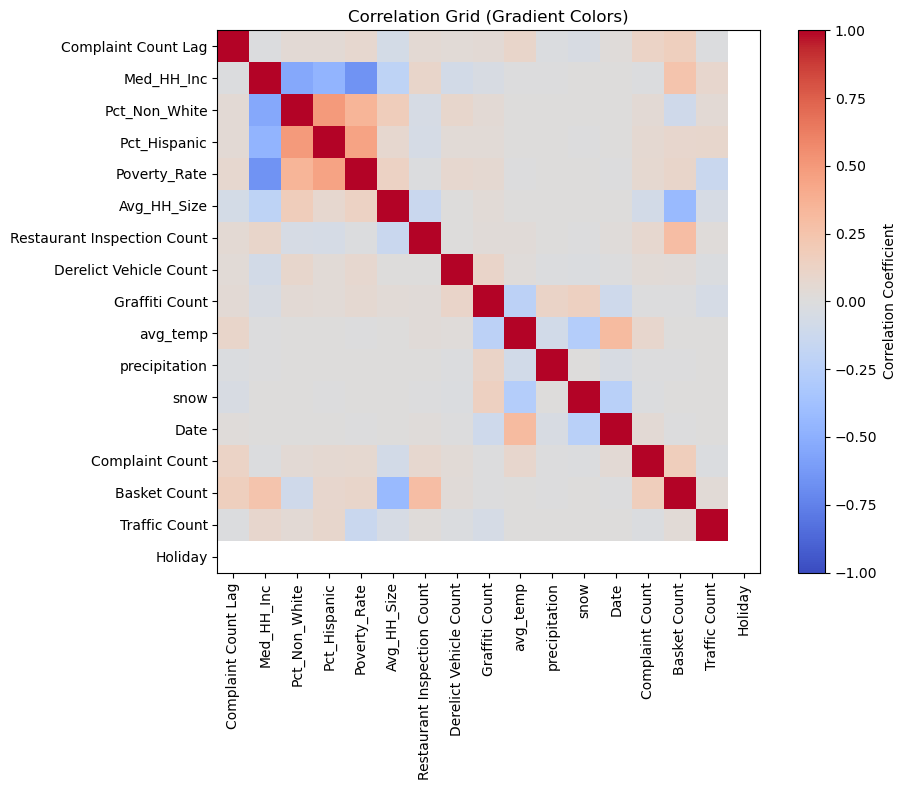

In [34]:
DSNY_final = DSNY_final.apply(pd.to_numeric, errors='ignore')

DSNY_final['Week'] = DSNY_final['Week'].astype(str) 

correlation_matrix = DSNY_final.corr()

plt.figure(figsize=(10, 8))

plt.imshow(correlation_matrix, cmap="coolwarm", interpolation="nearest", vmin=-1, vmax=1)

plt.xticks(range(correlation_matrix.shape[1]), correlation_matrix.columns, rotation=90)
plt.yticks(range(correlation_matrix.shape[1]), correlation_matrix.columns)

plt.colorbar(label="Correlation Coefficient")

plt.title("Correlation Grid (Gradient Colors)")

plt.tight_layout()
plt.show()

### Time series of complaint count

Next, we plotted a time series heatmap of total complaint counts by "Week" and "Day of the Week" to further analyze the temporal patterns of trash-related complaints across NYC. 

In line with our observations, complaint counts generally increase during warmer months (particularly in summer) compared to the beginning and end of the year. However, contrary to our initial expectations, there are generally more complaints on weekdays than on weekends. Nonetheless, the heatmap clearly indicates a generally consistent weekly pattern, with certain days showing higher complaint frequencies.

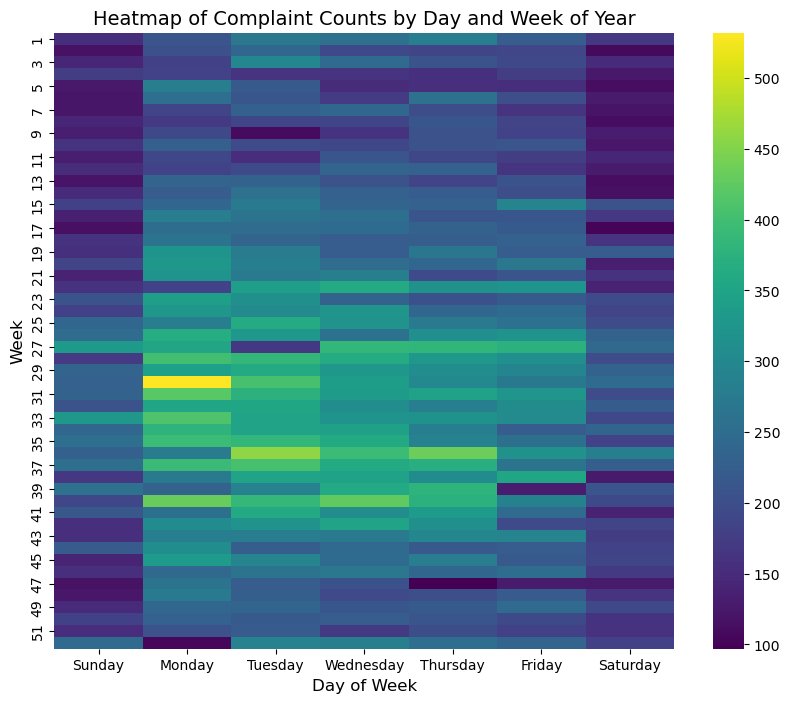

In [35]:
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
DSNY_final['Day of Week'] = pd.Categorical(DSNY_final['Day of Week'], categories=day_order, ordered=True)

DSNY_final_heatmap = DSNY_final.copy()

DSNY_final_heatmap['Week'] = DSNY_final['Week'].astype(int)

heatmap_data = DSNY_final_heatmap.pivot_table(
    index='Week', columns='Day of Week', values='Complaint Count', aggfunc='sum', fill_value=0
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    cmap='viridis', 
    annot=False,    
    fmt="d",         
    cbar=True       
)
plt.title('Heatmap of Complaint Counts by Day and Week of Year', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Week', fontsize=12)
plt.show()

### Map of Complaint Count in relation to highly-correlated factors

#### Create a Mapping Master Dataframe

In [36]:
DSNY_final_grouped = DSNY_final.groupby('DSNY_ID').agg({
    'Complaint Count': 'sum',
    'Complaint Count Lag': 'sum',         
    'Pct_Non_White': 'mean',    
    'Pct_Hispanic': 'mean',  
    'Poverty_Rate': 'mean',  
    'Avg_HH_Size': 'mean',  
    'Restaurant Inspection Count': 'sum',
    'Derelict Vehicle Count':'sum',
    'Basket Count': 'mean'      
}).reset_index()

# Rename columns
DSNY_final_grouped.rename(columns={
    "Complaint Count": "2023 Annual Total of Complaint Count",
    "Complaint Count Lag": "2022 Annual Total of Complaint Count",
    "Pct_Non_White": "2023 Share of Non-White Population",
    "Pct_Hispanic": "2023 Share of Hispanic-Latino Population",
    "Poverty_Rate": "2023 Poverty Rate", 
    "Avg_HH_Size": "2023 Average Household Size",
    "Restaurant Inspection Count": "2023 Annual Total of Restaurant Inspection Count",
    "Derelict Vehicle Count": "2023 Annual Total of Derelict Vehicle Count",
    "Basket Count": "2023 Annual Total of Basket Count"
}, inplace=True)

In [37]:
DSNY_final_grouped = DSNY_final_grouped.merge(DSNY_boundary, on="DSNY_ID", how="right")
DSNY_final_grouped = gpd.GeoDataFrame(DSNY_final_grouped, geometry=DSNY_final_grouped['geometry'], crs="EPSG:4326")
DSNY_final_grouped = DSNY_final_grouped.to_crs(DSNY_boundary.crs)

#### Mapping Dependent and Independent Variables

Then, we created a series of maps to visualize the spatial distribution of trash-related complaints with correlated variables. The following highlights are made:

- Spots with high complaint counts in 2023 is generally the same as that of 2022, with hotspots stretching all the way from south of the Central Park all the way to northern Brooklyn. This indicates that lagged complaint count is a powerful predictor of the next year's pattern.
- Whereas in other regions, complaint counts tend to correspond spatially with areas of lower non-white population share, lower Hispanic-Latino population share, and lower poverty rates, the Bronx Borough stands out as the only area where high complaint counts align with the opposite trends.
- Higher complaint counts aligns with areas with smaller average households, likely due to density of development and increased ground traffic. High complaint counts also correspond with areas with a high frequency of restaurant inspections and denser litter basket placement. This likely reflects dense business development and human activity, as seen in areas such as Midtown Manhattan.
- Complaints also tend to occur in areas with a high prevalence of derelict vehicles, except in the area spanning Midtown Manhattan to the southern tip of Manhattan, where complaints are less likely driven by a lack of management and more reflective of active business corridors.

In [38]:
metrics = ["2023 Annual Total of Complaint Count", "2022 Annual Total of Complaint Count", "2023 Share of Non-White Population", "2023 Share of Hispanic-Latino Population",
           "2023 Poverty Rate", "2023 Average Household Size", "2023 Annual Total of Restaurant Inspection Count", "2023 Annual Total of Derelict Vehicle Count", 
           "2023 Annual Total of Basket Count"]

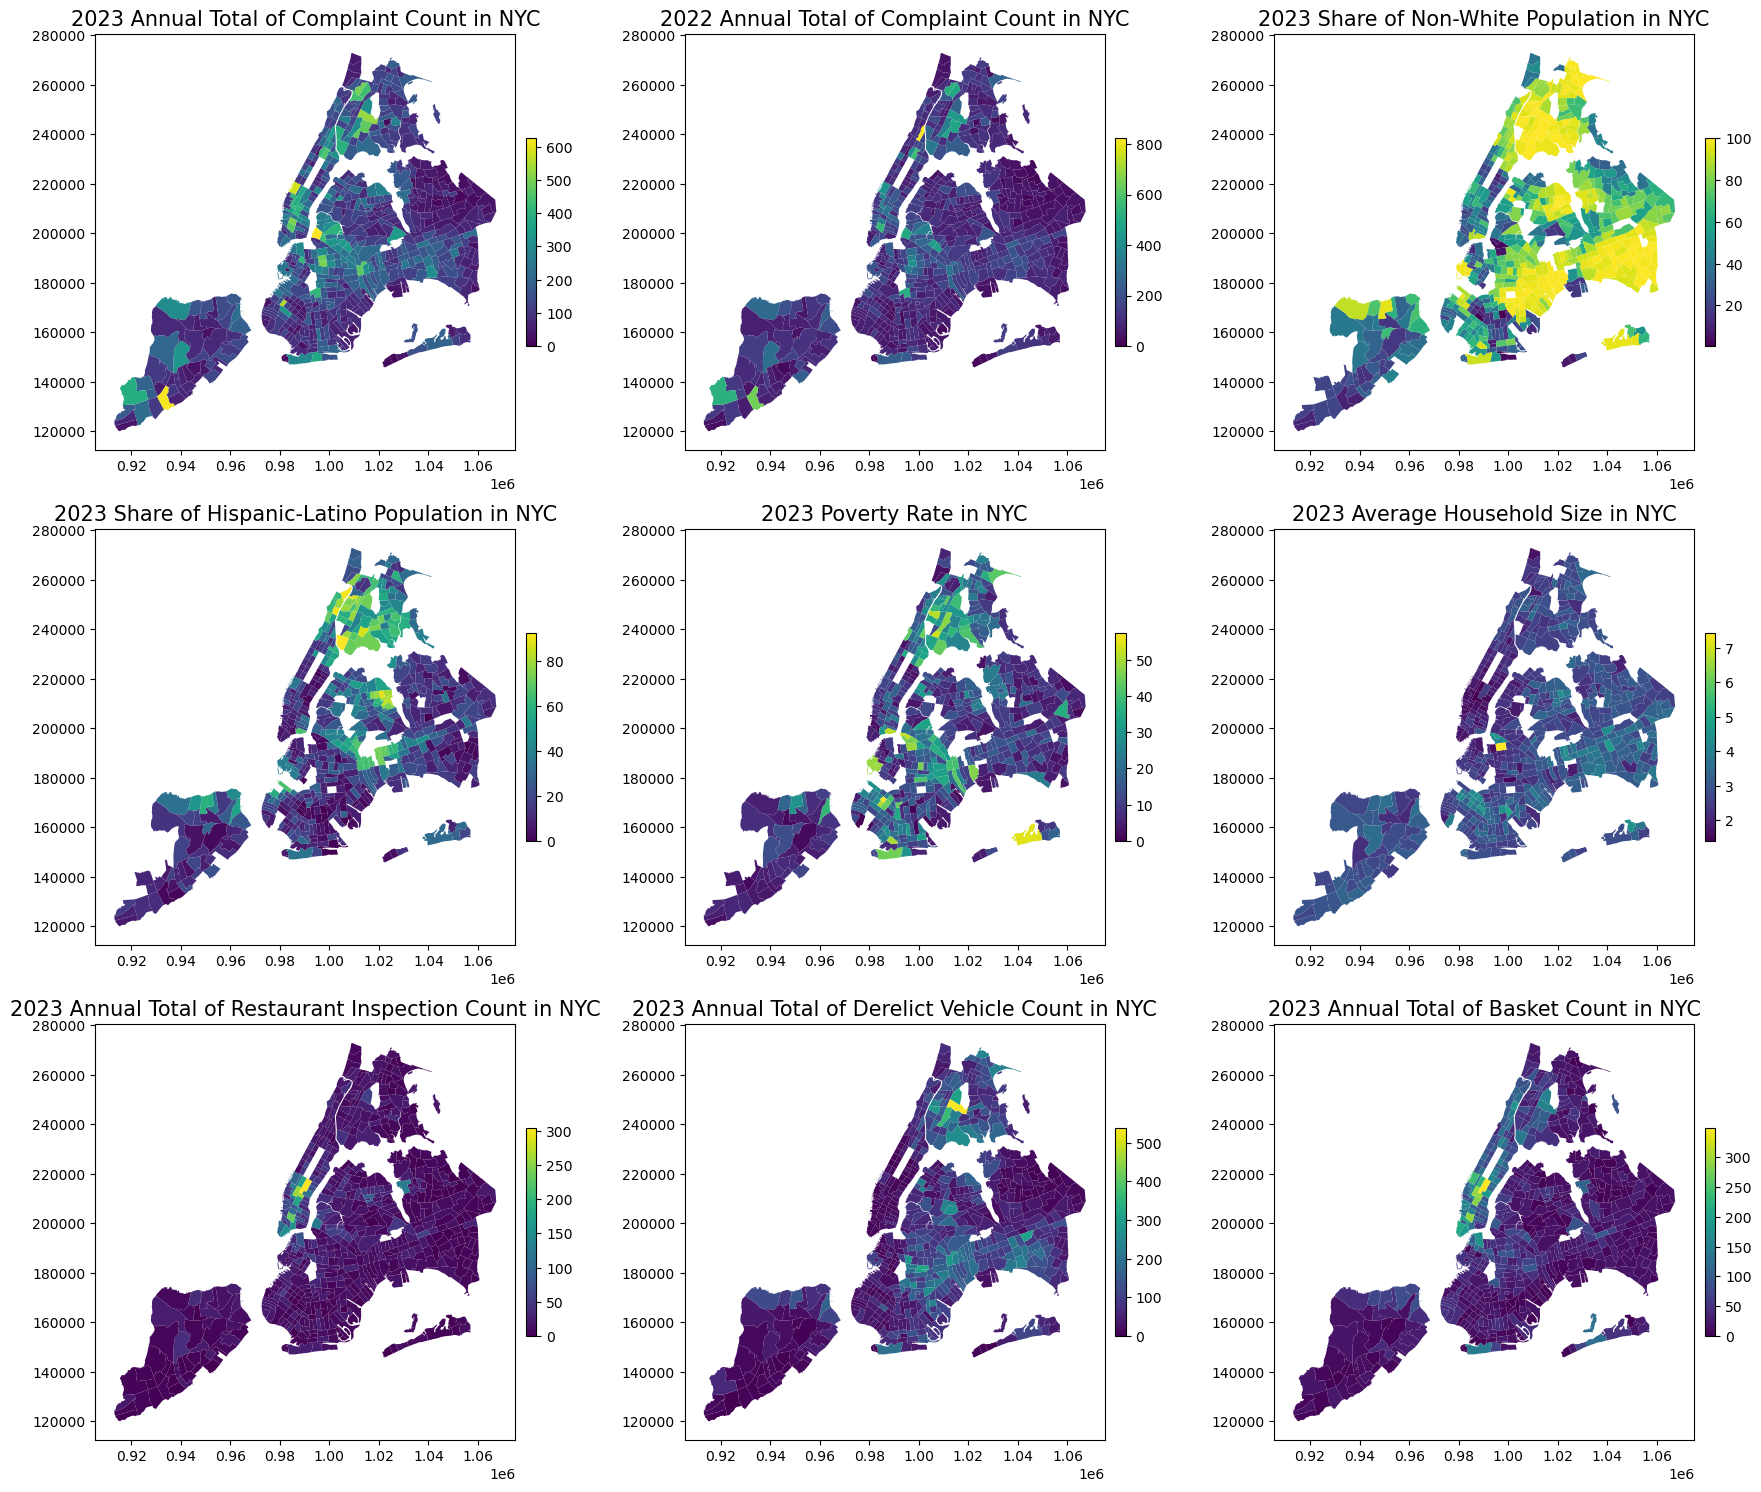

In [39]:
num_cols = 3
num_rows = -(-len(metrics) // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows)) 

axes = axes.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    DSNY_final_grouped.plot(
        column=metric, 
        cmap="viridis", 
        legend=True, 
        ax=ax,
        legend_kwds={
            'shrink': 0.5,  
            'location': 'right', 
            'pad': 0.02,
            'aspect': 20   
        }
    )
    ax.set_title(f"{metric} in NYC", fontsize=15)

# Turn off unused subplots
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

### Chart of Complaint Count with Natural Factors

Finally, we analyzed the relationship between trash-related complaints and daily temperature. Consistent with our observations from the time series heatmap, we found a positive correlation between higher complaint volumes and higher daily temperatures.

Text(0, 0.5, 'Daily Temperature (°F)')

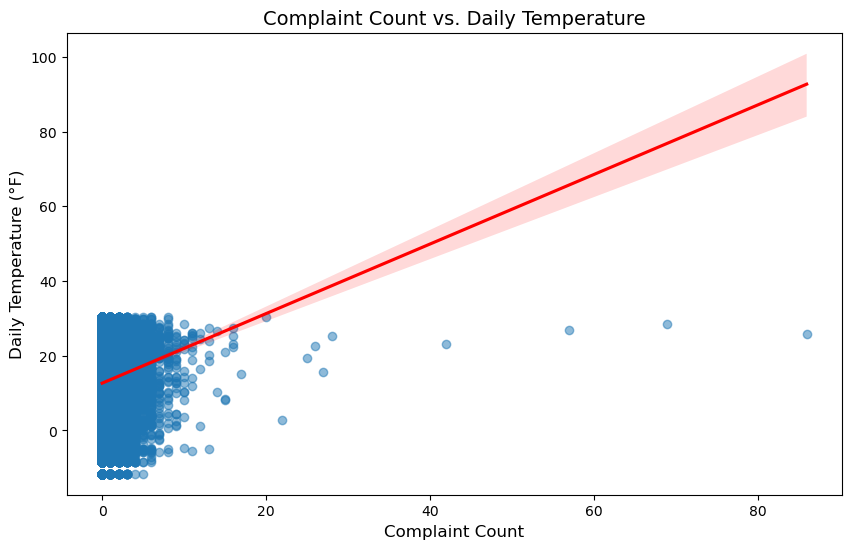

In [40]:
plt.figure(figsize=(10, 6))

sns.regplot(
    data=DSNY_final,
    x='Complaint Count',        
    y='avg_temp',
    scatter_kws={'alpha': 0.5},  
    line_kws={'color': 'red'},   
    ci=95                       
)

plt.title('Complaint Count vs. Daily Temperature', fontsize=14)
plt.xlabel('Complaint Count', fontsize=12)
plt.ylabel('Daily Temperature (°F)', fontsize=12)

## Save Data for Model Building

In [41]:
DSNY_master = DSNY_final.drop(columns=["geometry"])

DSNY_master.to_parquet('data/2_DSNY_master.parquet', index=False)